In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hypernetx as hnx
import model
import utils
import glob

# Initialization

In [5]:
cell_count = 456
gene_count = 100
infile_dir = "./../data/TEsmESC/"
labels = utils.load_pickle(glob.glob(infile_dir + "*.pickle")[0])
m = model.HyperGraph(n_cells=cell_count, n_genes=gene_count, infile_dir=infile_dir, gene_labels=labels)


# Graph Construction

In [6]:
m.construct_graph(0.85)
HG = m.HG 
m.prune_graph()

# Visualizing TE scores across cells (over time)

In [7]:
# heat_fig = sn.heatmap(PWscores[0, :, :], square=True)
    # as_file = heat_fig.get_figure()
    # path = "./../out/cell{i}.png".format(i = i + 1)
    # as_file.savefig(path)
    # ax.tick_params(left=False, bottom=False)

# Hypergraph Visualization

In [8]:
# plt.figure(dpi=360)
# plt.savefig("./hgraphsmall")
# utils.visualize_hyperedge_set(m)

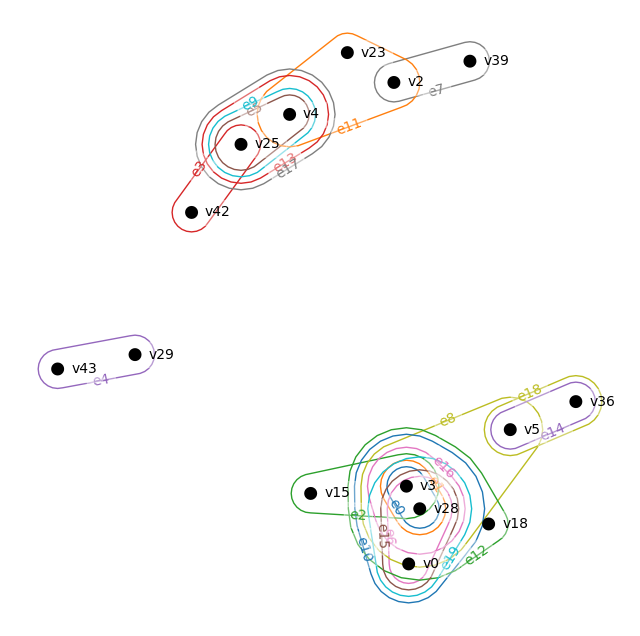

In [9]:
H_test = hnx.classes.Hypergraph.from_numpy_array(M = m.H[:, 60:80])
hnx.drawing.rubber_band.draw(H_test)

# Forming the graph Laplacian

In [10]:
m.set_graph_Laplacian()

# From *On Spectral Clustering: Analysis and an algorithm*

From L-normal:
1. Find k **largest** orthogonal eigen*vectors* (orthogonal to avoid vecs of repeated eigen*values*) of L
2. Make a matrix of 'em, n_genes x k = X
3. Y = Normalize each row of X to have unit length
4. Treat each row of Y as a point in R<sup>k</sup>, cluster into k-clusters via kmeans
5. Assign rows i (you can just use the gene labels vector) to cluster j iff row i in Y was assigned to cluster j 



In [11]:
sorted_eigvals, sorted_eigvecs = m.get_sorted_eigens()

# Visualizing Eigenvalues for Hyperparameter Selection

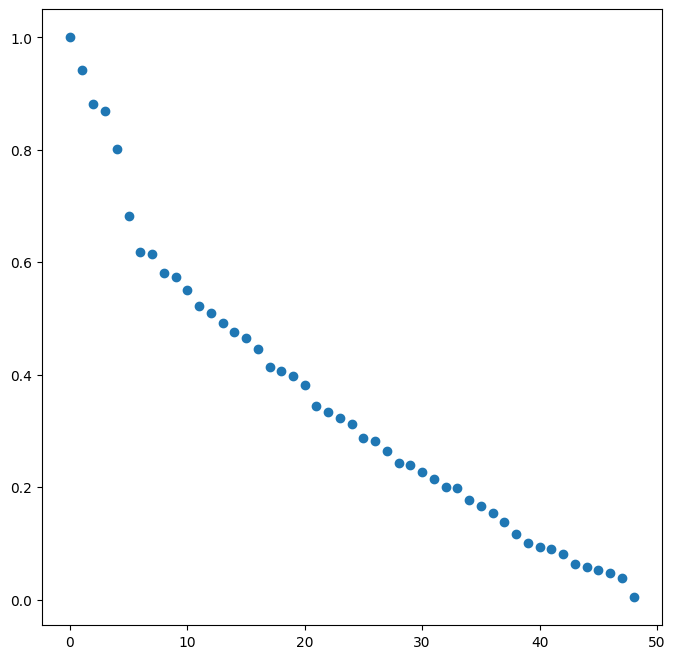

In [12]:
x = np.arange(m.n_genes)
plt.scatter(x, sorted_eigvals)

# Perform the clustering to determine the pathways

In [13]:
clusters = utils.get_clusters(5, sorted_eigvecs, m.gene_labels, 3)

In [14]:
clusters_dict = {}
for i in range(len(clusters)):
    clusters_dict[i] = clusters[i]

In [15]:
# utils.write_results(clusters_dict, './../results/mESC_pathways.csv')

# Analysis with hnx package

In [16]:
# H_uw = utils.get_unweighted_graph(m.H)
# hnx.drawing.rubber_band.draw(H_uw)

In [17]:
Lap, index = hnx.algorithms.laplacians_clustering.norm_lap(HG, weights=True)
Lap = Lap.toarray()

In [18]:
# Lap.shape[0] == m.n_genes

In [19]:
evals, evecs = np.linalg.eig(Lap)

# sort eigenvals, then sort eigenvecs by the eigenvals
sorted_i = np.flip(np.argsort(evals))
sorted_evals = evals[sorted_i] # sort the vals
sorted_evecs = evecs[:,sorted_i] # sorts the columns

# Sanity check to ensure eigenvecs got sorted
eps = 0.0001
min_index = np.argmin(evals)
if (np.sum(np.abs(np.abs(evecs[:,min_index]) - np.abs(sorted_evecs[:,Lap.shape[0] - 1])) < eps) != Lap.shape[0]):
    raise ValueError("Incorrectly sorted eigenvalues")


Text(0, 0.5, 'Normalised Eigenvalues')

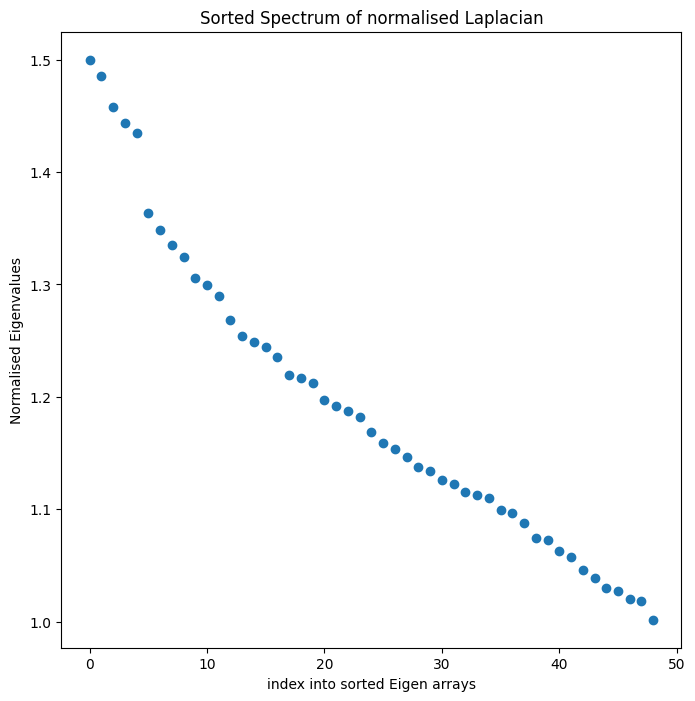

In [20]:
x_ax = np.arange(Lap.shape[0])
plt.scatter(x_ax, sorted_evals)
plt.title('Sorted Spectrum of normalised Laplacian')
plt.xlabel('index into sorted Eigen arrays')
plt.ylabel('Normalised Eigenvalues')

In [21]:
hnx_clusters = hnx.algorithms.laplacians_clustering.spec_clus(HG, k=5, weights=True)
# utils.write_results(hnx_clusters, './../results/mESC_pathways_hnx.csv')